In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [2]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh
from tqdm import tqdm


# Settings

In [3]:
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_MH_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_MH_up.pckl"),
    "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_MH_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_MH_up.pckl"),
}


In [4]:
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# helper functions

In [5]:
# interpolation function to find the discovery threshold using a pandas.DataFrame input
def get_scaler(x, thresh):
    return np.power(
        10,
        np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
            np.log10(-np.log10(thresh))
        ),
    )


In [6]:
def scaling_estimation(df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5):
    """ Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors """

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new
        
    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1
    
    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [7]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])

dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.47937914 13.47937914 16.64221592 ... 23.82743744  0.
   0.        ]
 [17.02848656 17.02848656 20.63478084 ... 20.27620928  0.
   0.        ]
 [19.13943583 19.13943583 22.97704711 ... 18.70430083  0.
   0.        ]]


# Atmospheric background

In [8]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [9]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true


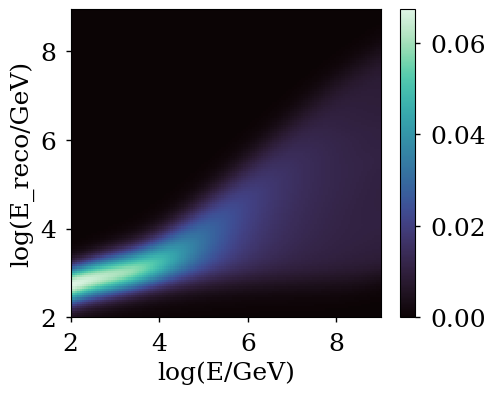

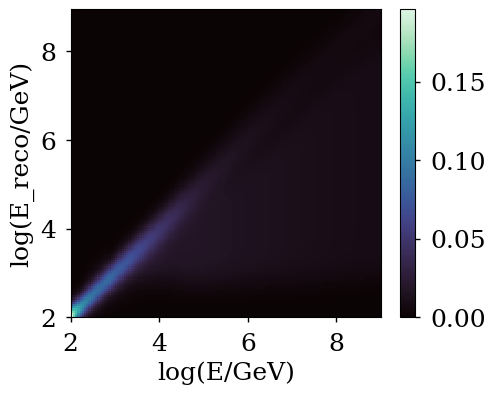

In [10]:
baseline_eres.plot()
plt.colorbar()

improved_eres.plot()
plt.colorbar()


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [11]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

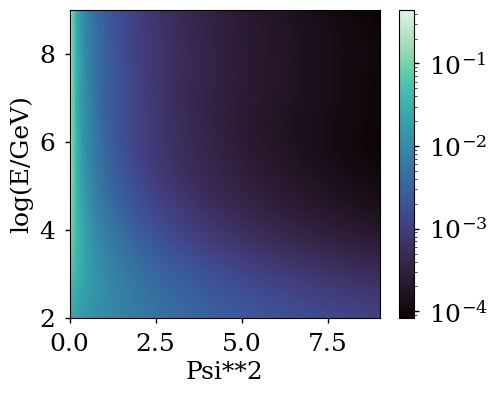

In [12]:
e_psi2_grid.plot(norm=LogNorm())
plt.colorbar()

# Flux definition

In [13]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 source parameters

In [14]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(join(LOCALPATH, "tenyr_paper_68_contour.txt"))

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [15]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [16]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


ngc 1068: 85.16199270234627


## PL+Cut: source parameters

In [15]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
Gamma_cut = 2.0
logE_cut = 3.5 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


### scale the fluxes such that the event numbers match


In [19]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) 
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 1.4280688359555416
flux normalization before 5e-14 after 7.140344179777707e-14


### Plot 1D analysis slice histograms

# source $\nu_\mu$ : 85.2
# atmo. $\nu_\mu$ : 1171.1 (within 28 deg²)
# source $\nu_\mu$ : 85.2
# atmo. $\nu_\mu$ : 1171.1 (within 28 deg²)


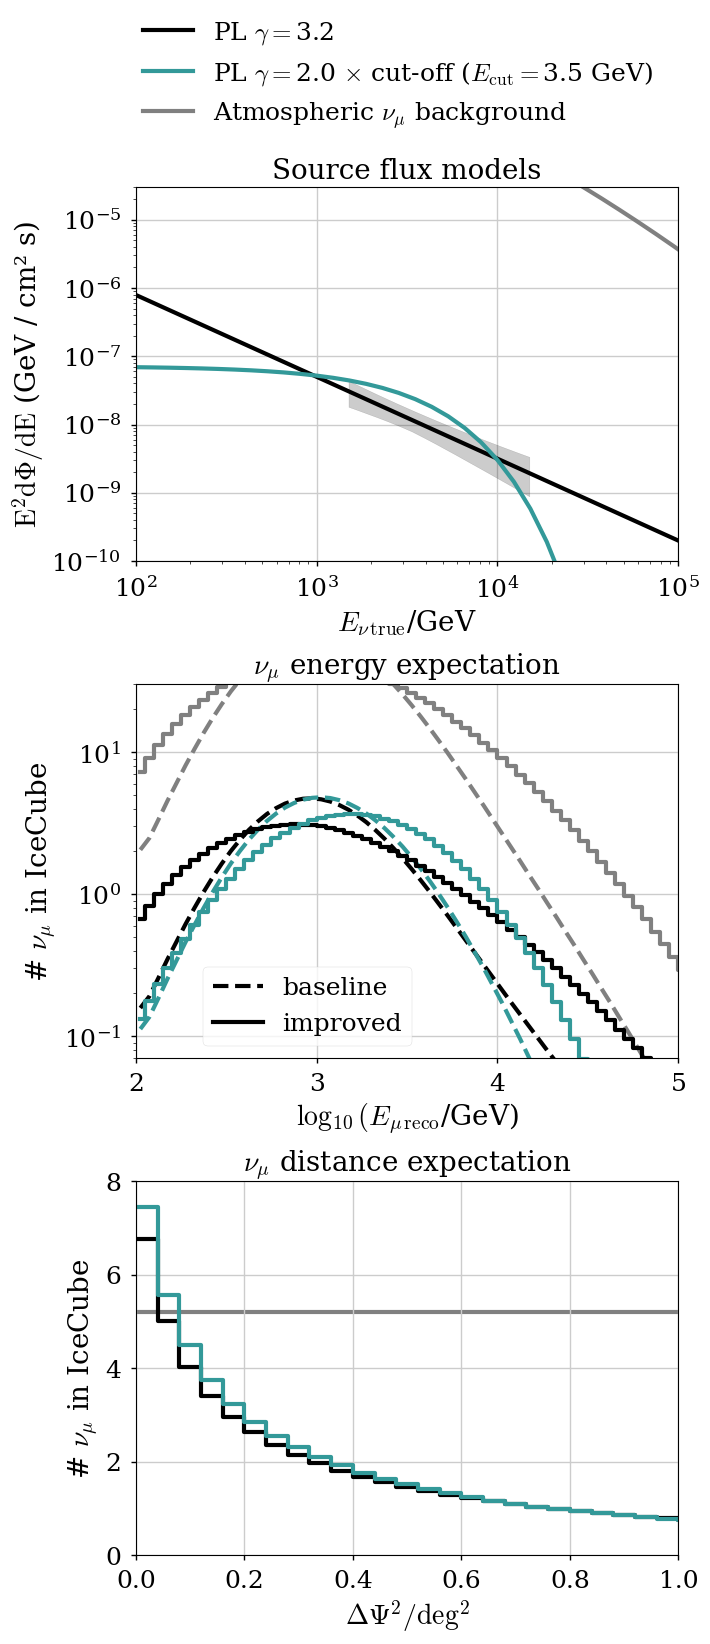

In [20]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=3, figsize=(7, 19))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PL $\gamma=${Gamma_cut} $\times$ "
    + rf"cut-off ($E_{{\rm cut}}=${logE_cut} GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    emids,
    array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1)
    * sq_deg
    * (emids**y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 3e-5)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)


### plot Event numbers in E_reco
ii = 0
evals = logE_reco_mids
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):

    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
        energy_resolution=eres,
    )

    # power law
    k_s_pl = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        ngc_flux,
    )

    # cutoff
    k_s_cut = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        ngc_cut_flux,
    )

    ax = axes[1]
    ax.plot(
        evals,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid" if e_name == "improved" else None,
        label=e_name,
        color="k",
        lw=3,
        ls="-" if e_name == "improved" else "--",
    )

    ax.plot(
        evals,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid" if e_name == "improved" else None,
        color="#339999",
        lw=3,
        ls="-" if e_name == "improved" else "--",
    )

    ax.plot(
        evals,
        k_b.sum(axis=0),
        drawstyle="steps-mid" if e_name == "improved" else None,
        color="gray",
        lw=3,
        ls="-" if e_name == "improved" else "--",
    )
    print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(2, 5)
ax.set_ylim(7e-2, 3e1)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    # label=rf"PL source $\nu_\mu$",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    # label=rf"EC source $\nu_\mu$",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    # label=rf"Atmospheric $\nu_\mu$",
    color="gray",
    lw=3, zorder=0
)

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

f.savefig(join(BASEPATH, f"plots/ngc_spectral_improved_dpsi.pdf"), bbox_inches="tight")


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know


For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$
* mu -> 0, k>0     --> P -> 0
* k -> 0, mu>0     --> P -> exp(-mu)
* k -> 0, mu -> 0  --> P -> 1

In [17]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    energy_resolution,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return poisson_llh(mu_i, k_i)


# NGC 1068
## Significance test Background vs. Background + Signal

In [18]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
        energy_resolution=baseline_eres,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=ngc_flux,  # powerlaw
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))


    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Asimov data sum:
Background: 1171.0715267504427
Signal: 85.16199270234627
Atmo-only normalization: [1.07271294]
Signal fit parameters: [1.  1.  3.2]
TS check: -350386.0769970139 (fit:  -350386.0769970139 )
-2 Delta LLH: 20.42661781888455
P-VALUE: 3.6678899658089966e-05 SIGNIFICANCE: 3.965124009957658

Plenum-1
Asimov data sum:
Background: 4964.813979933499
Signal: 363.81979587650505
Atmo-only normalization: [1.07327948]
Signal fit parameters: [1.  1.  3.2]
TS check: -314631.91161756165 (fit:  -314631.91161756165 )
-2 Delta LLH: 82.01095026469557
P-VALUE: 1.5543485851283023e-18 SIGNIFICANCE: 8.70741991371418

Plenum-2
Asimov data sum:
Background: 12557.131826216524
Signal: 915.994212952213
Atmo-only normalization: [1.07294627]
Signal fit parameters: [1.  1.  3.2]
TS check: -279392.93064199784 (fit:  -279392.93064199784 )
-2 Delta LLH: 214.36913629807532
P-VALUE: 2.8205480828401433e-47 SIGNIFICANCE: 14.394029766556619



## Significance test Background vs. Background + Signal with improved energy resolution

In [23]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    for key in e_res_files:
        # energy smearing matrix
        with open(e_res_files[key], "rb") as f:
            eres = pickle.load(f)
        eres.normalize(axis=1)
        print(key)
        print("- " * 10)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
            energy_resolution=eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution=eres,
            phi_scaling=1,
            flux_shape=ngc_flux,  # powerlaw
        )
        k_i = k_s + k_b

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        dct = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            energy_resolution=eres,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, **dct)
        # ... and fit both hypotheses!
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        print("Atmo-only normalization:", out_bckg[0])

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        print("Signal fit parameters:", out_comp[0])
        # print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        # calculate p-value and significance with Wilks'
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = norm.isf(pval)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("")


IceCube
baseline
- - - - - - - - - - 
Atmo-only normalization: [1.07272457]
Signal fit parameters: [0.99999567 1.00000719 3.20006427]
P-VALUE: 3.667890263960775e-05 SIGNIFICANCE: 3.9651239905683857

1:1
- - - - - - - - - - 
Atmo-only normalization: [1.07272268]
Signal fit parameters: [1.00003476 0.99993359 3.19997217]
P-VALUE: 2.36640305811299e-05 SIGNIFICANCE: 4.068444350263445

improved-20
- - - - - - - - - - 
Atmo-only normalization: [1.07272297]
Signal fit parameters: [1.00004641 0.99997227 3.19999921]
P-VALUE: 2.3094087884083596e-05 SIGNIFICANCE: 4.074122452958207

improved-50
- - - - - - - - - - 
Atmo-only normalization: [1.0727234]
Signal fit parameters: [1.00003091 1.00004776 3.19999043]
P-VALUE: 2.3158792944382658e-05 SIGNIFICANCE: 4.073471177531833

Plenum-1
baseline
- - - - - - - - - - 
Atmo-only normalization: [1.07328004]
Signal fit parameters: [1.00000493 0.99983633 3.19986745]
P-VALUE: 1.554349631019601e-18 SIGNIFICANCE: 8.707419837418826

1:1
- - - - - - - - - - 
Atmo-o

## Disc. potential vs dec

In [24]:
thresholds = [sigma5]
# idents = ["IceCube"]
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=5)

tmp = []  # save output here
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config)

        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], dec=dec, **bg_config)
            aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], dec=dec, **src_config)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, bckg_histo, sindec_mids, axis=1),
            energy_resolution=baseline_eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            baseline_eres,
            1,
            ngc_flux,  # powerlaw
        )
        # calculate an estimate for the flux scaling (black magic)
        scaler = 6 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        count = 0
        while len(current_thresholds) > 0:
            
            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                baseline_eres,
                scaler,
                ngc_flux,  # powerlaw
            )
            k_i = k_s + k_b

            dct = dict(
                shape="powerlaw",
                mu_b_base=k_b,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_flux.E0,
                phi_0=ngc_flux.norm,
                energy_resolution=baseline_eres,
            )
            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_2d_composite(x, **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )

            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                "n_b": np.sum(k_b),
                "n_sig": np.sum(k_s),
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


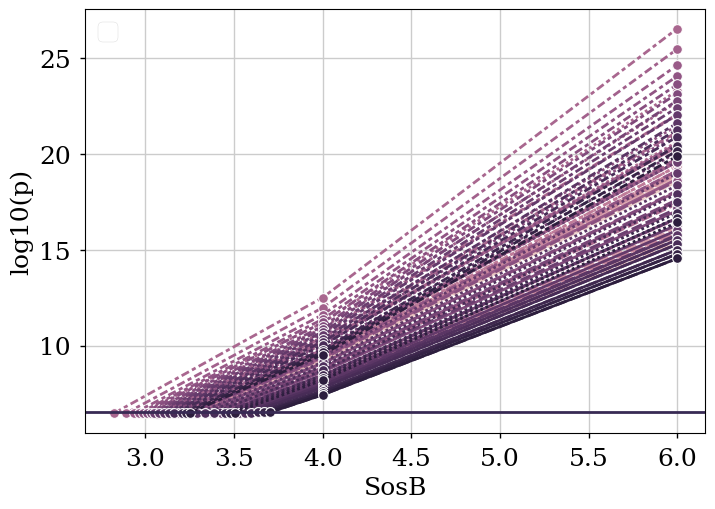

In [25]:
df = pd.DataFrame(tmp)
ax = sns.lineplot(
    data=df, y="log10(p)", x="SosB", hue="dec", marker="o", style="ident"
)
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)


In [26]:
df = pd.read_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))

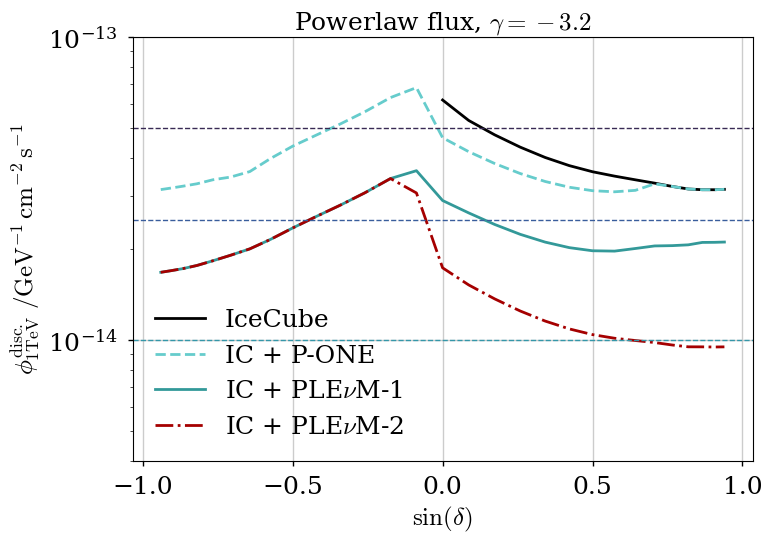

In [27]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5)) * PHI_NGC,
    columns=["disc5"],
).reset_index()

f, ax = plt.subplots()
for ident, series in flux.groupby(["ident"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_NGC, ls="--", lw=1, color=colorlist[0])  # , label="NGC 1068 flux")
ax.axhline(
    PHI_NGC / 2, ls="--", lw=1, color=colorlist[1]
)  # , label="NGC 1068 flux / 2")
ax.axhline(
    PHI_NGC / 5, ls="--", lw=1, color=colorlist[2]
)  # , label="NGC 1068 flux / 5")

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.legend(loc=3, frameon=False)
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
ax.set_ylim(4e-15, 1e-13)
f.savefig(join(BASEPATH, "plots/ngc_disc_pot.pdf"), bbox_inches="tight")


## Power law vs. Power-law with cutoff
### normal vs. improved E resolution

In [28]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
detector_conf = [{"key": k, "identifier": det_plotting[k]["label"]} for k in idents]

eres_conf = (
{"e_file": e_res_files["baseline"], "e_name": "Baseline"},
{"e_file": e_res_files["1:1"], "e_name": "Removed bias"},
{"e_file": e_res_files["improved-20"], "e_name": "20% improv."},
{"e_file": e_res_files["improved-50"], "e_name": "50% improv."},
)
# livetime relative to 10yrs

detector_configurations = []
for dc, eresc in product(detector_conf, eres_conf):
    detector_configurations.append(dc | eresc)
detector_configurations = pd.DataFrame(detector_configurations)

detector_configurations

,key,identifier,e_file,e_name
0,IceCube,IceCube,/home/lisajsch/repos/Plenum/local/energy_smear...,Baseline
1,IceCube,IceCube,/home/lisajsch/repos/Plenum/local/idealized_ar...,Removed bias
2,IceCube,IceCube,/home/lisajsch/repos/Plenum/local/improved_0.2...,20% improv.
3,IceCube,IceCube,/home/lisajsch/repos/Plenum/local/improved_0.5...,50% improv.
4,P-ONE,IC + P-ONE,/home/lisajsch/repos/Plenum/local/energy_smear...,Baseline
5,P-ONE,IC + P-ONE,/home/lisajsch/repos/Plenum/local/idealized_ar...,Removed bias
6,P-ONE,IC + P-ONE,/home/lisajsch/repos/Plenum/local/improved_0.2...,20% improv.
7,P-ONE,IC + P-ONE,/home/lisajsch/repos/Plenum/local/improved_0.5...,50% improv.
8,Plenum-1,IC + PLE$\nu$M-1,/home/lisajsch/repos/Plenum/local/energy_smear...,Baseline
9,Plenum-1,IC + PLE$\nu$M-1,/home/lisajsch/repos/Plenum/local/idealized_ar...,Removed bias


### Significance

In [29]:
pvals_ngc = []
for (identifier, es_ident), series in detector_configurations.groupby(
    ["identifier", "e_name"], sort=False
):
    print(es_ident, identifier)
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[series.key.iloc[0]], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[series.key.iloc[0]], **ngc_src_config)
    ## add the other detector configs to IceCube
    if series.key.iloc[0] != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        eres = pickle.load(f)
    eres.normalize(axis=1)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
        energy_resolution=eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        eres,
        1,
        ngc_cut_flux,  # powerlaw with cutoff
    )
    k_i = k_s + k_b

    if ii == 0:
        print("Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s))
    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
        energy_resolution=eres,
    )
    pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, 1, Gamma_cut, logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pvals_ngc.to_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))


Baseline IceCube
/home/lisajsch/repos/Plenum/local/energy_smearing_MH_up.pckl
Asimov data sum: Background = 1171.0715267504427 , Signal = 85.16199270234625
bckg params: [0.99334994 0.76822272 3.22197363]
global params: [0.99928809 1.10499827 1.89101539 3.42626849]
true params: (1, 1, 2.0, 3.5)
P-VALUE: 0.43813840436749274 SIGNIFICANCE: 0.1556907245680535
pval check: 0.4358901427076325 ratio: 0.994868603990317

Removed bias IceCube
/home/lisajsch/repos/Plenum/local/idealized_artificial_energy_smearing_MH_up.pckl
Asimov data sum: Background = 1171.0715267504427 , Signal = 85.16199270234624
bckg params: [0.99736128 0.70495812 3.11524973]
global params: [0.99919565 1.10123466 1.88878721 3.42884003]
true params: (1, 1, 2.0, 3.5)
P-VALUE: 0.07181758902537079 SIGNIFICANCE: 1.4623870429022918
pval check: 0.07078305639922958 ratio: 0.9855949964322006

20% improv. IceCube
/home/lisajsch/repos/Plenum/local/improved_0.2_artificial_energy_smearing_MH_up.pckl
Asimov data sum: Background = 1171.07152

### Nice significance summary plot

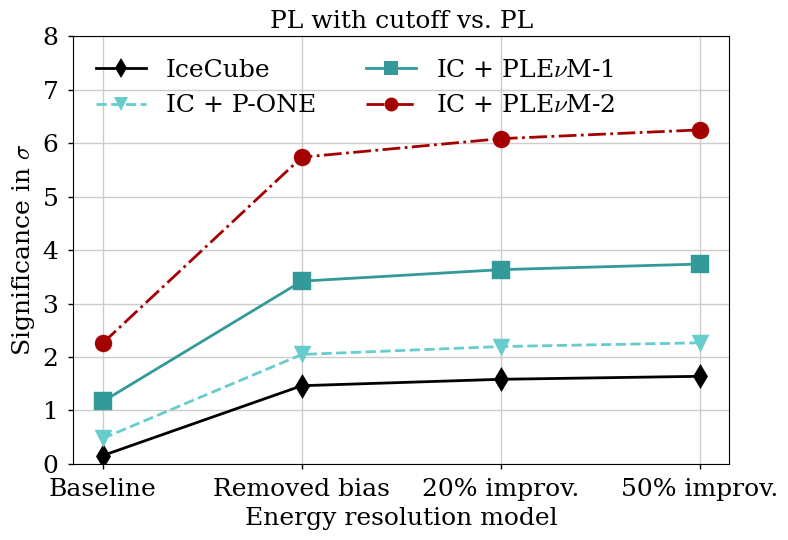

In [30]:
pval_df = pd.read_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))
f, ax = plt.subplots()
for ident, series in pval_df.groupby(["key"]):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(0, 8)
ax.legend(loc=2, ncol=2, frameon=False) #, fontsize=18)
ax.set_title("PL with cutoff vs. PL") #, fontsize=18)
ax.set_xlabel("Energy resolution model") #, fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$") #, fontsize=18)
f.tight_layout()
f.savefig("../../plots/cutoff_sigma_vs_eres_ngc.pdf")


## spectral fit vs. dec

scan for right threshold

In [31]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-90, 91, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        dec = dec
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=dec, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=dec, **src_config)
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += calc_aeff_factor(
                aeff_2d["IceCube"], dec=dec, **bg_config
            )
            aeff_factor_signal += calc_aeff_factor(
                aeff_2d["IceCube"], dec=dec, **src_config
            )

        # asimov data
        # improved energy resolution
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, bckg_histo, sindec_mids, axis=1),
            energy_resolution=improved_eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution=improved_eres,
            phi_scaling=1,
            flux_shape=ngc_cut_flux,
        )
        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        while len(current_thresholds) > 0:

            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                energy_resolution=improved_eres,
                phi_scaling=scaler,
                flux_shape=ngc_cut_flux,
            )
            k_i = k_s + k_b

            dct = dict(
                mu_b_base=k_b,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm, 
                energy_resolution=improved_eres,
            )
            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_2d_composite(
                x, shape="powerlaw with cutoff", **dct
            )
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, Gamma_cut, logE_cut),
                approx_grad=True,
            )
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                "n_sig": np.sum(k_s),
                "out_bg": out_bckg,
                "out_comp": out_comp,
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))


100%|██████████| 37/37 [03:29<00:00,  5.65s/it]


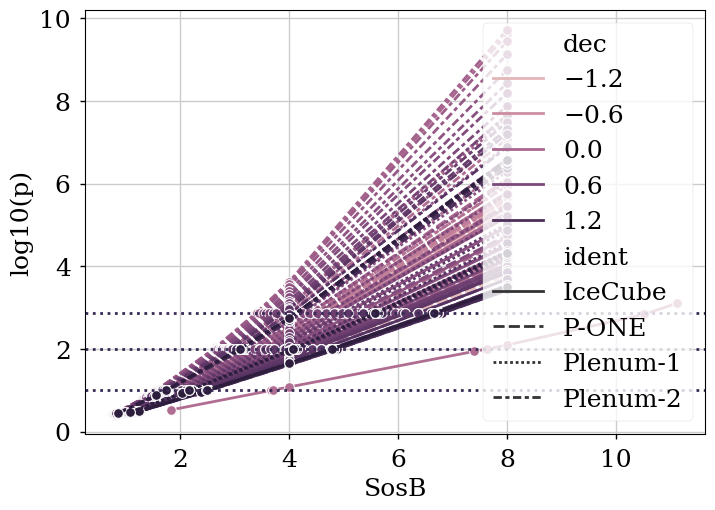

In [32]:
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB" # "scaler" # 
ax = sns.lineplot(
    data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend()

## plotting


In [33]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3)) * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01)) * ngc_cut_flux.norm
flux["5%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05)) * ngc_cut_flux.norm
flux["10%"] = df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
flux = flux.reset_index()

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm


### plot various thresholds

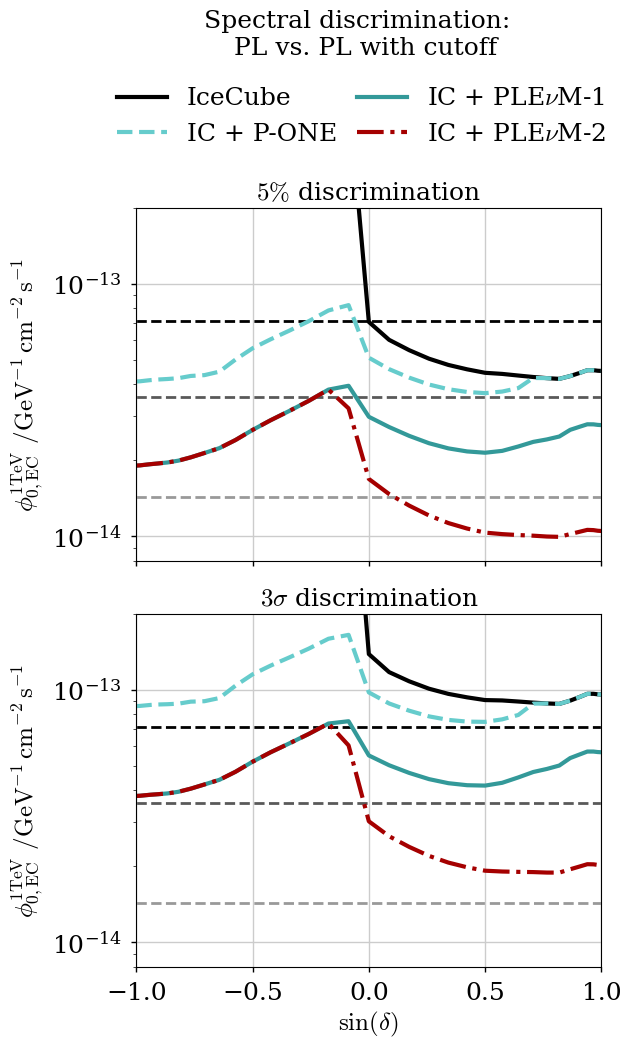

In [34]:
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby(["ident"]):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3, 
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    #fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
f.savefig("../../plots/ngc_spectral_disc_pot.pdf", bbox_inches="tight")
